Работа выполнена студентами группы М8О-411Б-19: \
Терешков Алексей \
Мамченков Дмитрий \
Алимов Исмаил

# Подготовка

Импорт необходимых библиотек, установка глобальных переменных, необходимых для решения

In [1]:
import pandas as pd
import numpy as np
import random

import apimoex
import requests

import matplotlib.pyplot as plt
from numpy.typing import ArrayLike

In [2]:
stock_names = ['RASP', 'GAZP', 'DSKY', 'SBER', 'KMAZ', 'RUAL']
start_date = '2020-04-01' 
end_date = '2022-04-22'

# Теоретические выкладки:

Заменим операцию $ r_t^\top x_t$ на $ (\vec{r_t} \cdot \vec{x_t})$

В таком случае:
$$ f_t(x) = -\log (\vec{r} \cdot \vec{x}) $$

$$\nabla f_t(x) = -\frac{\vec{r}} {(\vec{r} \cdot \vec{x})} $$

Формула перехода:
$$ x_{t+1} = \Pi_{\mathcal{D}}(x_t - \alpha_t\nabla f_t(x_t)) $$ 
 


### Стохастический градиентный спуск 
Стохастический градиентный спуск  (англ. stochastic gradient descent) −
 оптимизационный алгоритм, отличающийся от обычного градиентного спуска тем, что градиент оптимизируемой функции считается на каждом шаге не как сумма градиентов от каждого элемента выборки, а как градиент от одного, случайно выбранного элемента

Для дополнительного задания определим стохастический градиент как вектор, состоящий из нулей везде, кроме случайно выбранной позиции. На этой случайно выбранной позиции будет находиться тот элемент, что находился на этой позиции на элементе r

### Выбор длины шага

Длину шага выберем ситуативно, но вне зависимости от ситуации оставим его константной, так как ситуация на рынке меняется, а затухающая длина шага будет способствовать застыванию наших ответов, отчего на дистанции будет решать ситуация на рынке, которая была в начале.

# Функции

Определение основных функций, необходимых для решения

In [3]:
def load_data(stock_names=stock_names, start=start_date, end=end_date):
    df = pd.DataFrame()
    with requests.Session() as session:
        for stock in stock_names:
            data = apimoex.get_board_history(session, stock, start=start, end=end, columns=['CLOSE', 'TRADEDATE'])
            df_stock = pd.DataFrame(data)
            df_stock.set_index('TRADEDATE', inplace=True)
            df[stock] = df_stock
    return df


def prepare_r(df_stocks):
    return (df_stocks.shift(-1) / df_stocks).dropna()

In [4]:
def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [5]:
def get_grad(r, x):
    return -r / np.dot(r, x)


def get_sgrad(r, x):
    rdot = np.dot(r, x)
    rand_value = random.randint(0, 5)
    new_r = np.array([0 for i in range(6)])
    new_r[rand_value] = r[rand_value]
    return -new_r / rdot

In [6]:
def descent_step(this_state, r, alpha, grad_func):
    x = this_state
    new_x = simplex_projection(x - alpha * grad_func(r, x))
    return new_x


def descent(begin_state, df_r, grad_func, lr_scheduler=lambda i: 0.1):
    x = begin_state

    n = df_r.shape[0]

    profit = []
    vectors = [x]

    profit = 1.0
    profit_vec = [profit]

    for i in range(n):
        r = df_r.iloc[i].values  # "после этого алгоритму открывается вектор рыночных доходностей rt из истории наблюдений"
        alpha = lr_scheduler(i)
        profit *= (r * x).sum()
        profit_vec.append(profit)
        new_x = descent_step(x, r, alpha, grad_func) # "алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации."
        x = new_x # в момент времени t алгоритм должен предложить распределение средств между активами xt 
        vectors.append(new_x)

    return (vectors, profit_vec)
    

# Загрузка данных

In [7]:
data = load_data()
data_clear = data.dropna()
r = prepare_r(data_clear)

In [8]:
data_clear.head()

,RASP,GAZP,DSKY,SBER,KMAZ,RUAL
TRADEDATE,,,,,,
2020-04-01,97.76,180.06,90.12,184.78,51.0,24.755
2020-04-02,99.40,187.04,90.62,186.95,50.9,24.955
2020-04-03,99.10,189.77,94.42,185.64,53.6,24.830
2020-04-06,100.92,191.10,97.80,190.70,54.4,25.755
2020-04-07,98.98,191.22,98.12,197.63,54.8,26.050


In [9]:
r.head()

,RASP,GAZP,DSKY,SBER,KMAZ,RUAL
TRADEDATE,,,,,,
2020-04-01,1.016776,1.038765,1.005548,1.011744,0.998039,1.008079
2020-04-02,0.996982,1.014596,1.041933,0.992993,1.053045,0.994991
2020-04-03,1.018365,1.007008,1.035798,1.027257,1.014925,1.037253
2020-04-06,0.980777,1.000628,1.003272,1.036340,1.007353,1.011454
2020-04-07,1.017175,1.015113,1.019160,1.013459,0.979927,0.988484


# Визуализация

<AxesSubplot: xlabel='TRADEDATE'>

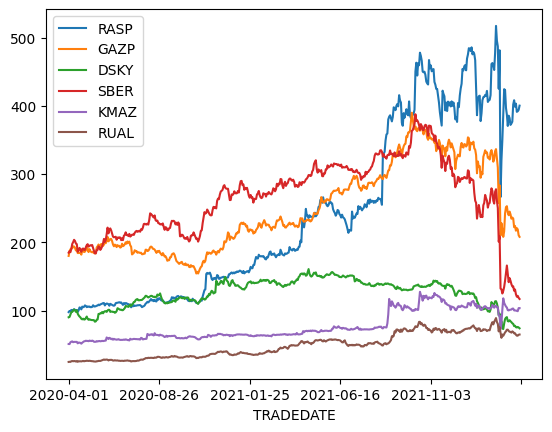

In [10]:
data_clear.plot()

In [11]:
data_clear

,RASP,GAZP,DSKY,SBER,KMAZ,RUAL
TRADEDATE,,,,,,
2020-04-01,97.76,180.06,90.12,184.78,51.0,24.755
2020-04-02,99.40,187.04,90.62,186.95,50.9,24.955
2020-04-03,99.10,189.77,94.42,185.64,53.6,24.830
2020-04-06,100.92,191.10,97.80,190.70,54.4,25.755
2020-04-07,98.98,191.22,98.12,197.63,54.8,26.050
...,...,...,...,...,...,...
2022-04-18,403.15,216.99,75.60,123.85,100.1,64.605
2022-04-19,391.15,220.72,75.20,120.30,99.5,63.200
2022-04-20,392.00,218.92,75.98,121.50,99.1,63.200


Подсчет прибыли для константного инвестора (без корректировки котировок)

In [56]:
vectors, naive_profit = descent(np.ones(r.shape[1]) * (1/r.shape[1]) , r, get_grad, lr_scheduler=lambda x: 0)

In [57]:
profit_to_date = pd.DataFrame(index=data_clear.index, columns=["profit"])
profit_to_date['profit'] = naive_profit

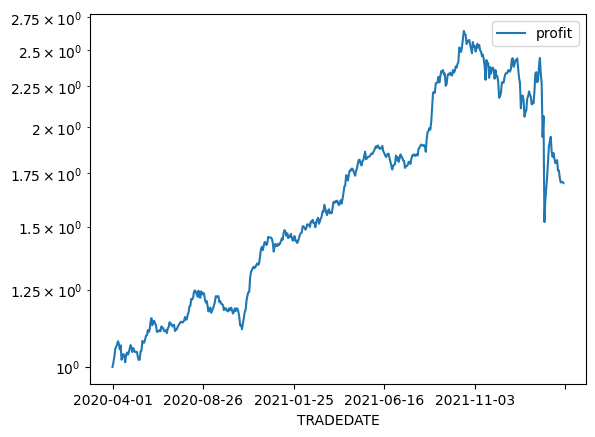

In [58]:
graph = profit_to_date.plot()
graph.set_yscale('log')

In [59]:
#final constant profit
profit_to_date['profit'][-1]

1.7014992521179437

# Решение

Решим задачу, используя алгоритм онлайн градиетного спуска

In [17]:
alpha_array = np.logspace(1, 10, 1000, base=5.1) * 0.0001

In [18]:
max_profit = [0]
best_alpha = -1.0

for i in alpha_array:
    vectors, profit = descent(np.ones(r.shape[1]) * (1/r.shape[1]) , r, get_grad, lr_scheduler=lambda x: i)
    if profit[-1] > max_profit[-1]:
      max_profit = profit
      best_alpha = i

In [19]:
best_alpha

0.43635803556937275

Для данного метода лучшей константой alpha оказалась 0.436358

In [20]:
profit_to_date = pd.DataFrame(index=data_clear.index, columns=["profit"])
profit_to_date['profit'] = max_profit

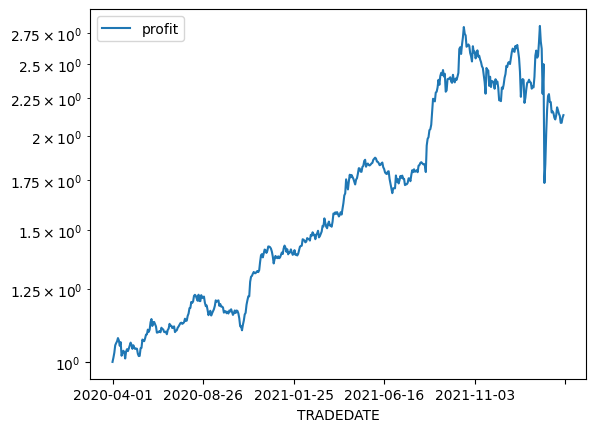

In [21]:
graph = profit_to_date.plot()
graph.set_yscale('log')

In [22]:
#final profit
profit_to_date['profit'][-1]

2.1356268078260854

# Дополнительное задание (OSGD)

Решим задачу, используя алгоритм онлайн стохастического градиентного спуска



In [39]:
vectors, profit = descent(np.ones(r.shape[1]) * (1/r.shape[1]) , r, get_sgrad, lr_scheduler=lambda x: 0.5)

In [40]:
profit_to_date = pd.DataFrame(index=data_clear.index, columns=["profit"])
profit_to_date['profit'] = profit

<AxesSubplot: xlabel='TRADEDATE'>

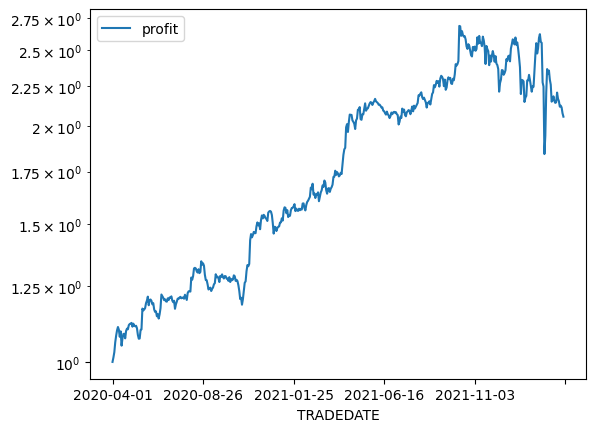

In [41]:
graph = profit_to_date.plot()
graph.set_yscale('log')
graph

In [42]:
#final profit
profit_to_date['profit'][-1]

2.0575741340013183

In [43]:
profit_list = []
for i in range(1000):
    vectors, profit = descent(np.ones(r.shape[1]) * (1/r.shape[1]) , r, get_sgrad, lr_scheduler=lambda x: 0.5)
    profit_list.append(profit[-1])

# Вычисление прибыльностей

In [60]:
osgd_average_profit = np.average(profit_list)

osgd_max_profit = np.max(profit_list)
osgd_min_profit = np.min(profit_list)

In [61]:
osgd_average_profit / max_profit[-1]

0.719809760633837

In [62]:
osgd_max_profit / max_profit[-1]

1.3972465190492143

In [63]:
osgd_min_profit / max_profit[-1]

0.3441230546622279

In [65]:
max_profit[-1]

2.1356268078260854

In [66]:
naive_profit[-1]

1.7014992521179437

# Вывод: 

Наивный алгоритм (если взять равномерно все активы и не пересобирать портфель) выдает прибыльность 1.7. Алгоритм OGD выдает прибыльность 2.14.

Алгоритм OSGD в среднем слабее, чем алгоритм OGD, однако в некоторых случайных случаях он может выдать результат больший в ~1.4 раз. 

Алгоритм OGD приносит прибыли не сильно выше роста рынка, однако ситуация на рынке не предсказывается очевидным образом, и даже такой результат - уже отлично.

Алгоритм OSGD лучше не использовать, в среднем он менее выгоден, чем OGD.